In [7]:
from tensorflow.keras import layers
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim), ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        #self._name = 'TransformerBlock_{}_{}_{}'.format(embed_dim, num_heads, ff_dim)
        # The name "TransformerBlock_64_4_64" is used 4 times in the model. All layer names should be unique.

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'att': self.att,
            'ffn': self.ffn,
            'layernorm1': self.layernorm1,
            'layernorm2': self.layernorm2,
            'dropout1': self.dropout1,
            'dropout2': self.dropout2,
        })
        return config

    def call(self, inputs, training, return_weights=False):
        if return_weights:
            attn_output, attn_weights = self.att(inputs, return_weights=return_weights)
        else:
            attn_output = self.att(inputs)

        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)

        if return_weights:
            return self.layernorm2(out1 + ffn_output), attn_weights
        else:
            return self.layernorm2(out1 + ffn_output)


In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, Add
from transformer import MultiHeadSelfAttention
from tensorflow import keras
from tensorflow.keras.utils import plot_model

# Hyperparameters
embed_dim = 128  # 512
num_heads = 8
ff_dim = 128  # 2048
dropout_rate = 0.1

# Define the layers
input_layer = Input(shape=(10, embed_dim))

att = MultiHeadSelfAttention(embed_dim, num_heads)
ffn = keras.Sequential([Dense(ff_dim, activation="relu"), Dense(embed_dim), ])
layernorm1 = LayerNormalization(epsilon=1e-6)
layernorm2 = LayerNormalization(epsilon=1e-6)
dropout1 = Dropout(dropout_rate)
dropout2 = Dropout(dropout_rate)

# Connect the layers
attn_output = att(input_layer)
attn_output = dropout1(attn_output)

# Duplicating inputs for visualization using Add()
combined_for_norm1 = Add()([input_layer, attn_output])  
out1 = layernorm1(combined_for_norm1)

ffn_output = ffn(out1)
ffn_output = dropout2(ffn_output)

# Duplicating inputs for visualization using Add() again
combined_for_norm2 = Add()([out1, ffn_output])  
final_output = layernorm2(combined_for_norm2)



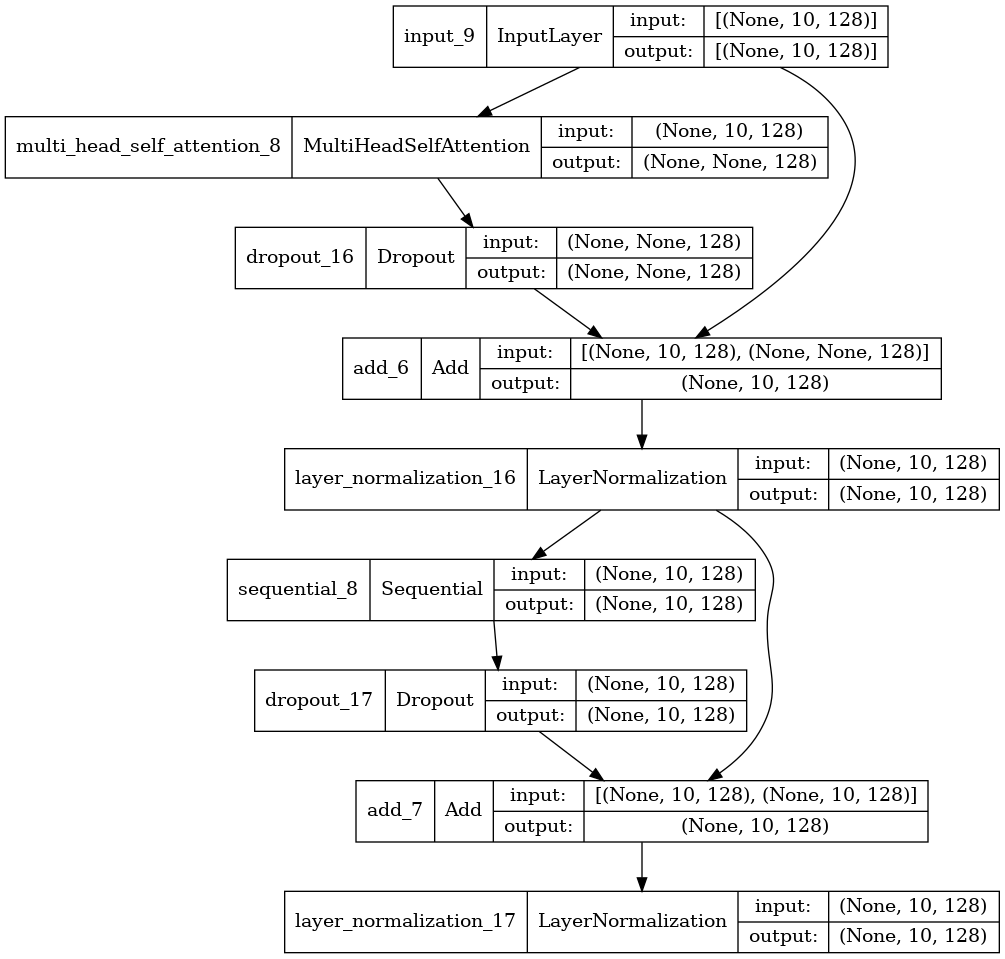

In [18]:

# Create the model
model = Model(inputs=input_layer, outputs=final_output)

# Visualize the model
plot_model(model, to_file='model.png', show_shapes=True)


In [20]:
def plot_model_custom_dpi(model, filename, dpi=300):
    import pydot
    import tensorflow as tf
    # Create the dot object
    dot = tf.keras.utils.model_to_dot(model, show_shapes=True)
    
    # Modify the dot object to set DPI
    graph = pydot.graph_from_dot_data(dot.to_string())
    graph[0].set_dpi(dpi)
    
    # Write the modified dot object to a file
    graph[0].write_png(filename)
    
dpi=300
plot_model_custom_dpi(model, 'transformer_block_internal_hidef_{}.png'.format(dpi), dpi=dpi)

위 코드에서는 Add() 레이어를 사용하여 입력들을 요소별로 더하고 있습니다. 원래의 Transformer 구조에서는 간단한 덧셈 연산 (input_layer + attn_output)을 사용하여 동일한 작업을 수행합니다.

두 방식 모두 텐서들을 요소별로 더하는 동일한 기능을 수행합니다. Add() 레이어를 사용하는 방식은 모델의 구조를 시각화할 때 더 명확하게 연산이 어떻게 이루어지는지 표현해 줄 수 있습니다.

따라서 코드와 원래의 Transformer 구조는 기능적으로 동일합니다. 다만, 시각화나 구현의 방식에서 약간의 차이가 있을 뿐임.

In the code above, the `Add()` layer is utilized to element-wise sum the inputs. In the original Transformer architecture, a simple addition operation (`input_layer + attn_output`) accomplishes the same task.

Both methods serve the same purpose of element-wise summing of tensors. The use of the `Add()` layer can offer a clearer representation of how operations are conducted when visualizing the model's architecture.

Thus, both the code and the original Transformer structure are functionally identical. The differences lie merely in the nuances of visualization and implementation approach.


https://chat.openai.com/c/b26a610e-7fd4-4536-8e97-f40702f15be2